# Stellar Classification
In this project I will be using random forests and neural network algorithims to classify stars. In astronomy classification of astronomical objects is a big subject since there are so many types of objects that can be observed in the night sky. The classification is based soley on their spectral charactersitics, like their redshift. Although there are many more features that come into play which I will dicuss in the project below. The dataset is collected from the Sloan Digital Sky Survey DR17. Here is an image from the survey:

![NGC1072](https://www.astro.princeton.edu/~rhl/PrettyPictures/NGC/NGC1072-mosaic.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
stars = pd.read_csv('star_classification.csv')
stars.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


The dataset contains 100,000 observations with 17 features and 1 class column which will be our target feature. It describes the observation to be either Galaxy, Star or Quasar object (QSO) which are high energy objects with large redshifts. Here is the list of all features and their meanings:

1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

Let's keep a close eye on the redshift since that is an important variable in determining the source, because we know space is expanding and light gets shifted as the object moves further away based on the doppler effect.
Before we make our model let's analyze the data a bit more and see if their is multicollinearity within the features which we might to need address.

In [3]:
stars['class'].value_counts()

,count
class,
GALAXY,59445
STAR,21594
QSO,18961


In [4]:
stars['class'].value_counts(normalize=True)

,proportion
class,
GALAXY,0.59445
STAR,0.21594
QSO,0.18961


We can see that galaxies make up most of the data with about 60%, then comes stars with about 21% and finally QSO which stands for Quasar object at about 19% of the data. Before I move onto feature selection I am going to find if there any missing values in the dataset.

In [5]:
stars.isnull().sum()

,0
obj_ID,0
alpha,0
delta,0
u,0
g,0
r,0
i,0
z,0
run_ID,0
rerun_ID,0


Seems like there are no missing values in the dataset. Now let's check for multicollinearity.

In [6]:
stars.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


Let's plot a heat map and see the correlation with class of all the features. But first we need to create dummy varibles for the 'class' column.

In [7]:
stars_copy = stars.copy().drop(['obj_ID','rerun_ID','run_ID','cam_col','field_ID','spec_obj_ID'\
                                ,'plate','MJD','fiber_ID'], axis=1)
class_dummies = pd.get_dummies(stars_copy['class'], prefix='class')
stars_copy = pd.concat([stars_copy, class_dummies], axis=1)
stars_copy = stars_copy.drop('class', axis=1)
stars_copy.head()

,alpha,delta,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,True,False,False
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,True,False,False
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,True,False,False
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,True,False,False
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,True,False,False


Now let's calculate the correlations and make a heat map.

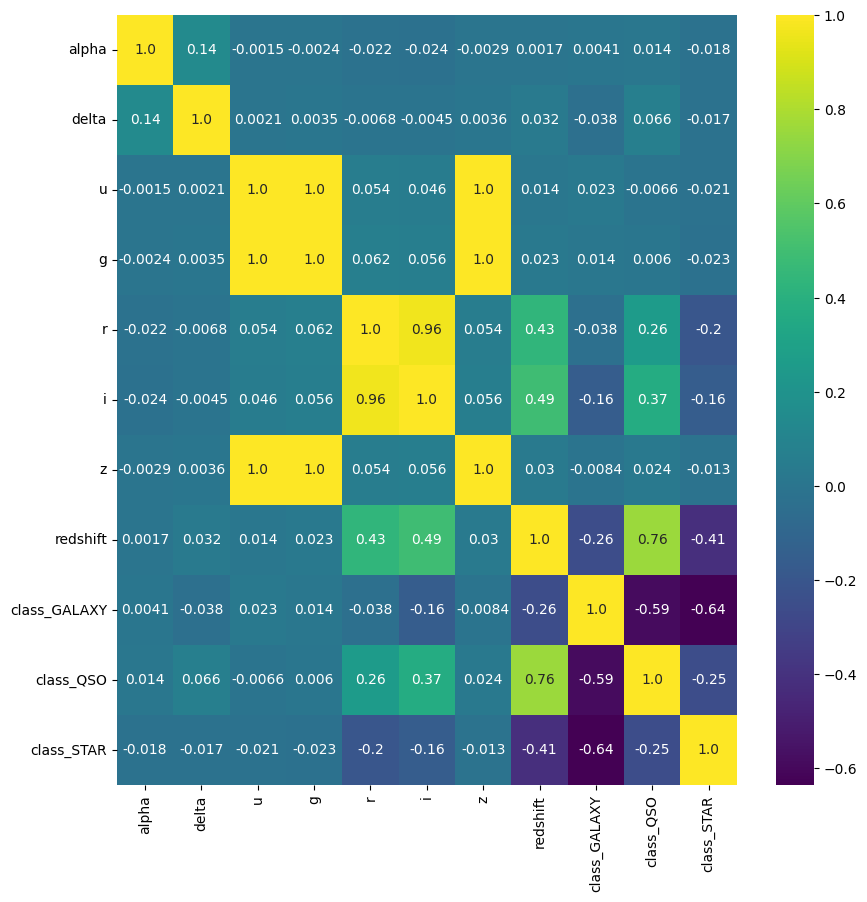

In [8]:
stars_copy.corr()
plt.figure(figsize=(10,10))
sns.heatmap(stars_copy.corr(), annot=True, fmt='.2', cmap='viridis')
plt.show()

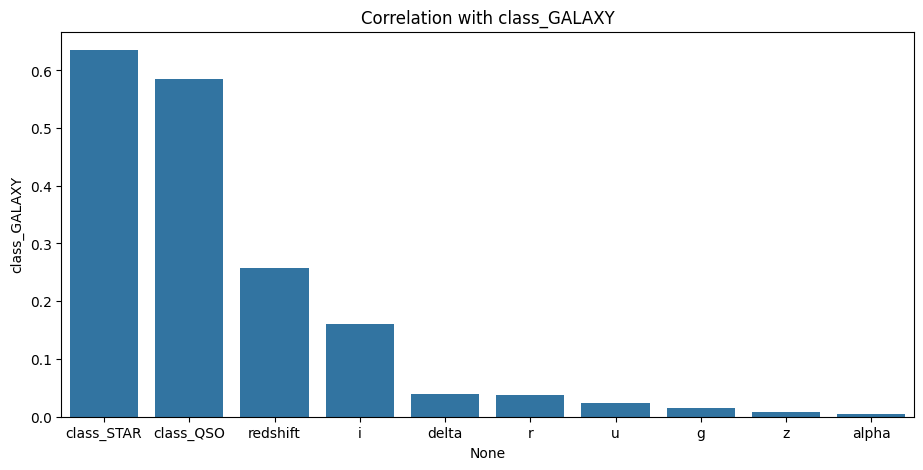

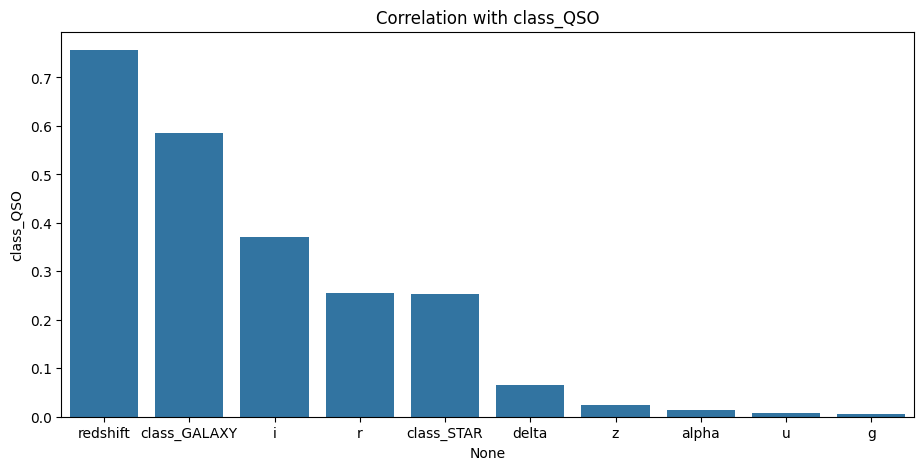

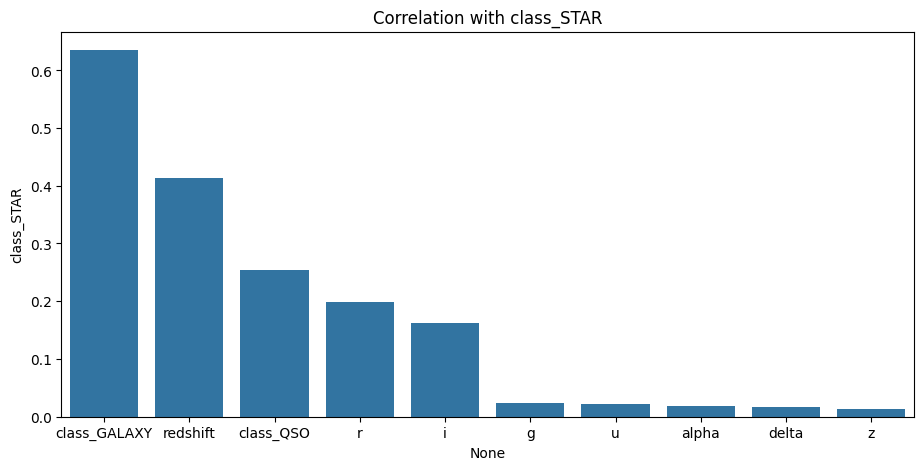

In [9]:
classes = ['class_GALAXY','class_QSO','class_STAR']
for class_obj in classes:
  sorted_correlation = stars_copy.corr()[class_obj].abs().sort_values(ascending=False)
  plt.figure(figsize=(11,5))
  sns.barplot(x=sorted_correlation[1:].index, y=sorted_correlation[1:])
  plt.title(f'Correlation with {class_obj}')
  plt.show()

Interesting! We got some good results by seeing the correlation with all the features and classes. We also did see some multicollinearity within the classes which we might have to investigate. But before we do that we should address any outliers in the dataset. We could do that with the help of boxplots. I will leave out target variables (classes).

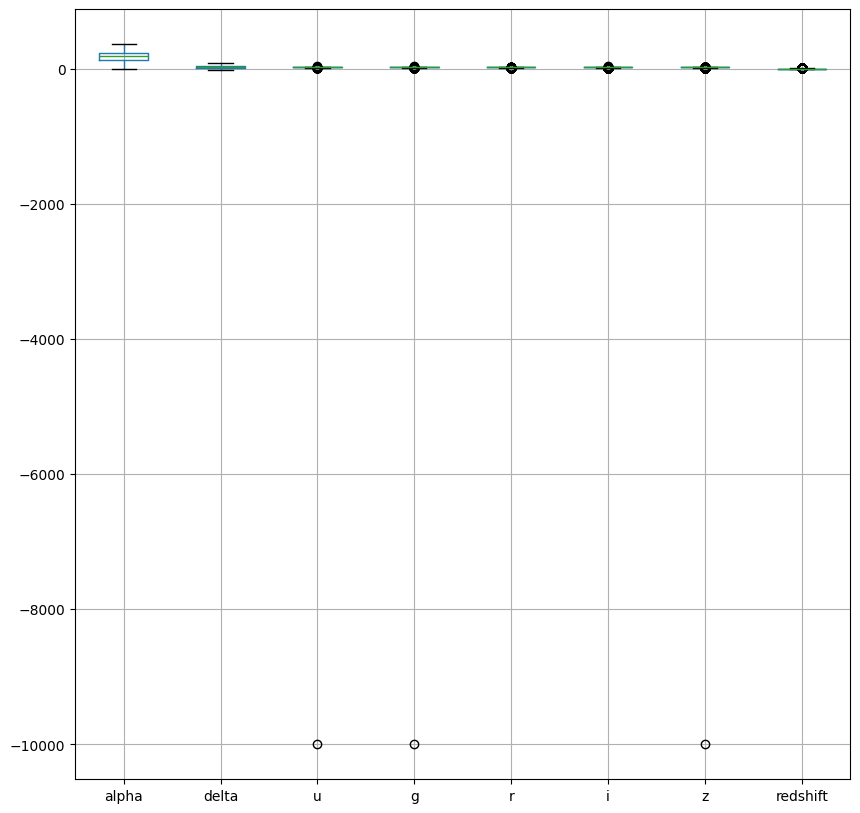

In [10]:
stars_copy.boxplot(column=['alpha','delta','u','g','r','i','z','redshift'], figsize=(10,10))
plt.show()

let's calculate the number of outliers.

In [11]:
def calculate_outliers(df,column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
  return outliers

for column in ['alpha','delta','u','g','r','i','z','redshift']:
  outliers = calculate_outliers(stars_copy,column)
  print(f'percentage of outliers in {column}: {len(outliers) / len(stars_copy) * 100:.2f}')

percentage of outliers in alpha: 0.00
percentage of outliers in delta: 0.00
percentage of outliers in u: 0.06
percentage of outliers in g: 0.10
percentage of outliers in r: 0.13
percentage of outliers in i: 0.20
percentage of outliers in z: 0.32
percentage of outliers in redshift: 8.99


We can see that the outliers do not make a large part of the dataset. Percentage of outliers in redshift make up 9% of the data which is not a large amount and the rest around 0.5% or less, knowning this we can leave the outliers as it is. We also know that the universe and is really, really big, and having outliers and unknown objects is very likely.

Let's address the multicollinearity between the features, by first calculating the VIF (variance inflation factor), anything greater than 5 could pose problems.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(stars_copy.drop(['class_GALAXY','class_QSO','class_STAR'], axis=1))
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


    feature          VIF
0     const   169.265416
1     alpha     1.021094
2     delta     1.023066
3         u   852.113179
4         g  2722.592703
5         r    32.943252
6         i    31.961217
7         z  1494.251938
8  redshift     1.389742


As suspected we did get high VIF values for u,g,r,i,and z since they are related to the object's brightness in different wavelengths. We could address this with feature selection and Ridge regression. Let me start off with ridge regression and I'll explore feature engineering later on if required. First I will make random forest model to predict the class of the object.  

## Decision Tree Model

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = stars[['alpha','delta','u','g','r','i','z','redshift']]
y = stars['class']

# strandardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

stars_new = pd.DataFrame(X_scaled, columns=X.columns)
stars_new = pd.concat([stars_new, y], axis=1)
stars_new.head()

,alpha,delta,u,g,r,i,z,redshift,class
0,-0.434604,0.425529,0.059755,0.054926,0.403962,0.046007,0.003937,0.079557,GALAXY
1,-0.339921,0.363402,0.088045,0.072456,1.584406,1.185097,0.092835,0.277096,GALAXY
2,-0.367251,0.582713,0.103327,0.067165,0.519745,0.150019,0.008808,0.092423,GALAXY
3,1.669523,-1.249105,0.004921,0.102210,1.059904,0.807610,0.018321,0.486770,GALAXY
4,1.737310,-0.150242,-0.080055,-0.092948,-1.697421,-1.767887,-0.098468,-0.630267,GALAXY


In [14]:
parameters = {'max_depth':[7,14,21,28],
              'criterion':['gini','entropy'],
              'class_weight':[None,'balanced']}
tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_scaled, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 7}
DecisionTreeClassifier(criterion='entropy', max_depth=7)


In [15]:
X = stars_new.drop('class', axis=1)
y = stars_new['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=7,random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print('Accuracy for training set:', tree.score(X_train, y_train))
print('Accuracy for test set:', accuracy_score(y_test, y_pred))

Accuracy for training set: 0.9721428571428572
Accuracy for test set: 0.9702333333333333


Let's plot the tree

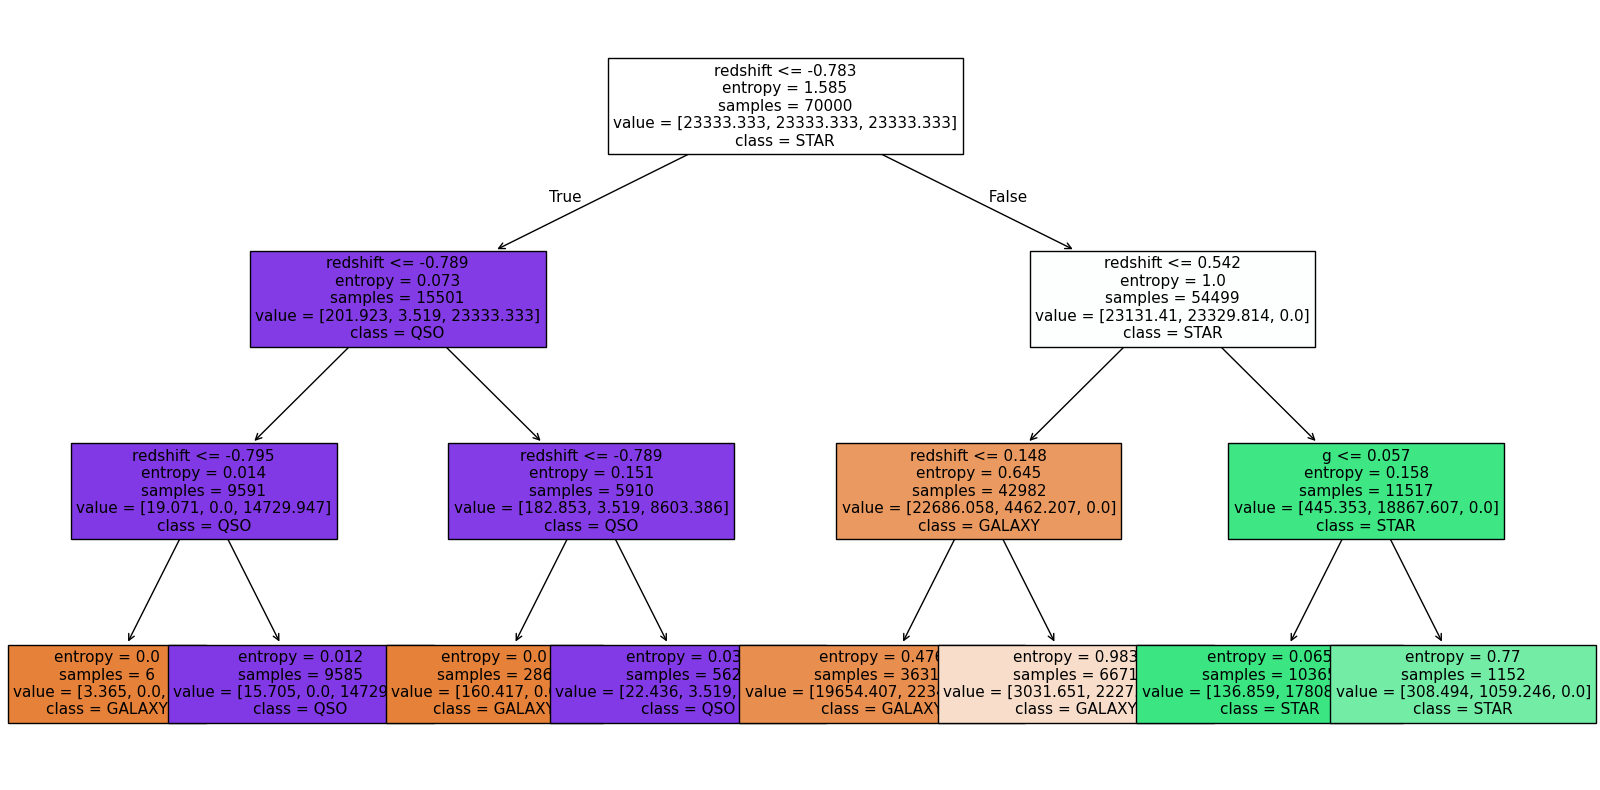

In [16]:
tree = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=3,
                              min_samples_split=10,
                              min_samples_leaf=6,
                              random_state=42)
tree.fit(X_train, y_train)

plt.figure(figsize=(20,10))
_= plot_tree(tree, feature_names=X.columns, class_names=['GALAXY','STAR','QSO'], filled=True, fontsize=11)
plt.show()

## Random Forest model

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print('Accuracy for training set:', rf.score(X_train, y_train))
print('Accuracy for test set:', accuracy_score(y_test, y_pred))

Accuracy for training set: 0.9999857142857143
Accuracy for test set: 0.9772333333333333


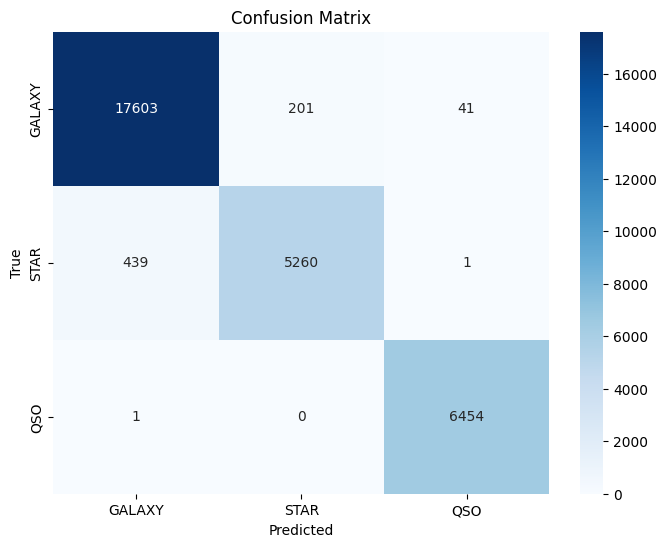

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['GALAXY','STAR','QSO'],
            yticklabels=['GALAXY','STAR','QSO'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

Precision: 0.9771098937005334
Recall: 0.9772333333333333
F1 Score: 0.9770695425945681


Looking at the random forest results we can see that the model seemed to perform really. The single decision tree classifier got an accuracy of 97%! At the level of accuracy we have to make sure the model is not overfitting. Although the test results were slightly lower by 0.2% which seems to indicate the model was indeed not overfitting. Looking at the plot of the desicion tree we see that the first node the model starts of which assumption that the observation is a star. The threshold is based on the redshift as the deciding factor, where redhshift below -0.783 is classified as a Quasar (remember the values are scaled, so they do not represent actual values of redshifts) and anything above that is classified as a star. From there on the model trickles down into subclasses based on redshifts and g values (green filter in photometric system). After I tried a random forest model to see any better results and while the training accuracy was better almost 100%, the test accuracy remained the same, but this insured the model was not overfitting, since random forest take the average of the all the trees. From there I used a confusion matrix to get the Precision, Recall and F1 scores all which stood around ~98%, very high! Before I move onto the neural network model, I would like to see the unscaled thresholds for redshift and g variables.

In [20]:
mean_redshifts = stars.groupby('class')['redshift'].mean()
mean_g = stars.groupby('class')['g'].mean()
print(mean_redshifts)

class
GALAXY    0.421596
QSO       1.719676
STAR     -0.000115
Name: redshift, dtype: float64


Looking at the original mean redshift values for all classes, we can see that Quasars have the highest redshfit values sitting around 1.7, followed by Galaxies at around 0.4 and finally stars sitting very close 0. Now let's move onto building a neural network model to see how well that performs.

## Neural Network Model

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder


X = stars_new.drop('class', axis=1)
y = stars_new['class']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu',),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,235 (12.64 KB)

 Trainable params: 3,235 (12.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8591 - loss: 0.3855 - val_accuracy: 0.9560 - val_loss: 0.1502
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9557 - loss: 0.1440 - val_accuracy: 0.9540 - val_loss: 0.1433
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9611 - loss: 0.1261 - val_accuracy: 0.9631 - val_loss: 0.1236
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9630 - loss: 0.1203 - val_accuracy: 0.9600 - val_loss: 0.1311
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9633 - loss: 0.1167 - val_accuracy: 0.9626 - val_loss: 0.1215
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9638 - loss: 0.1169 - val_accuracy: 0.9629 - val_loss: 0.1299
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9640 - loss: 0.1163 - val_accuracy: 0.9627 - val_loss: 0.1228
Epoch 8/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9663 - loss: 0

Let's quickly graph the epoch vs. val_loss score to see how well the model performed.

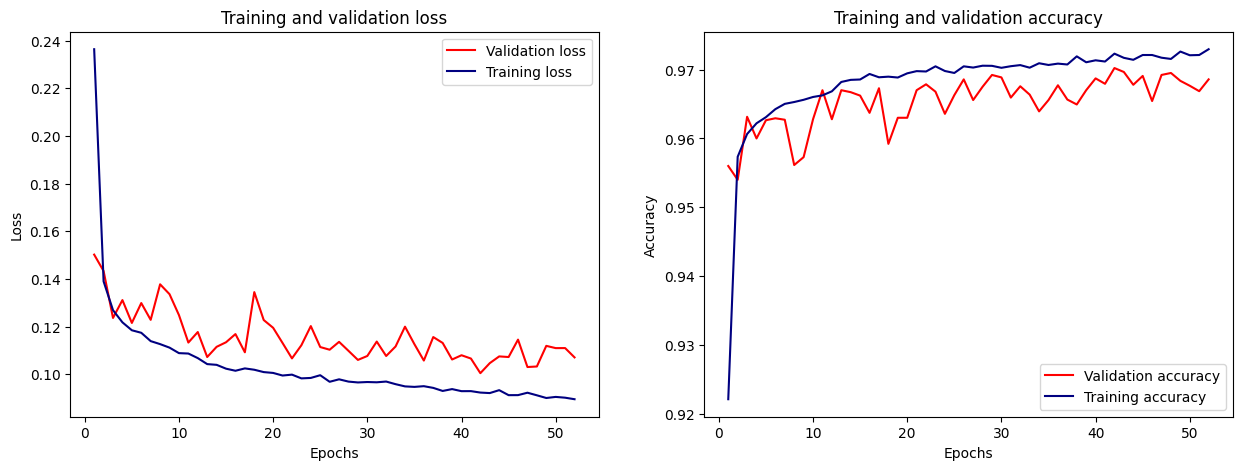

In [23]:
history = model.history.history
val_loss = history['val_loss']
training_loss = history['loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(val_loss) + 1)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(epochs, val_loss, 'r', label='Validation loss')
ax[0].plot(epochs, training_loss, 'navy', label='Training loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax[1].plot(epochs, training_accuracy, 'navy', label='Training accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

Looking at the Epochs vs. training and validation loss/accuracy we can see that in the loss graph both training and validation follow a general trend of decreasing with each epoch but the difference between training loss and validation loss seems to be increasing. The training loss being lower than the validation loss seems to indicate overfitting. This is further proven by the accuracy graph where the training accuracy is higher than the validation accuracy as the epoch gets larger. The Earlystopping stopped the training at epoch 26 which I would say helped the model to not overfit even more. Let's evaluate the model on test also and see the overall performance before I bring in L1 or L2 optimization, to regularize the model.

In [24]:
print('Accuracy for training set:', model.evaluate(X_train, y_train)[1])
print('Accuracy for test set:', model.evaluate(X_test, y_test)[1])

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9727 - loss: 0.0874
Accuracy for training set: 0.9732857346534729
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9721 - loss: 0.0995
Accuracy for test set: 0.9720333218574524


The perfomed pretty well with about 97% accuracy but I still need to add some regularization in the model, in this case I will use L2 or Ridge to make sure the it handles the multicollinearity better. I will also add droput layers to make the performance even better!

## Neural Network Model with Ridge Regression (L2) and Dropout layers

In [25]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

model_reg = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_reg.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_reg.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7585 - loss: 0.9048 - val_accuracy: 0.9154 - val_loss: 0.3729
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9145 - loss: 0.3955 - val_accuracy: 0.9446 - val_loss: 0.3263
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9261 - loss: 0.3559 - val_accuracy: 0.9446 - val_loss: 0.3051
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9305 - loss: 0.3331 - val_accuracy: 0.9451 - val_loss: 0.2904
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9366 - loss: 0.3146 - val_accuracy: 0.9456 - val_loss: 0.2823
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9374 - loss: 0.3064 - val_accuracy: 0.9459 - val_loss: 0.2759
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9417 - loss: 0.2921 - val_accuracy: 0.9517 - val_loss: 0.2671
Epoch 8/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9429 - loss: 0

Let's graph the loss and accuracy scores against the epoch to see how well the model performed.

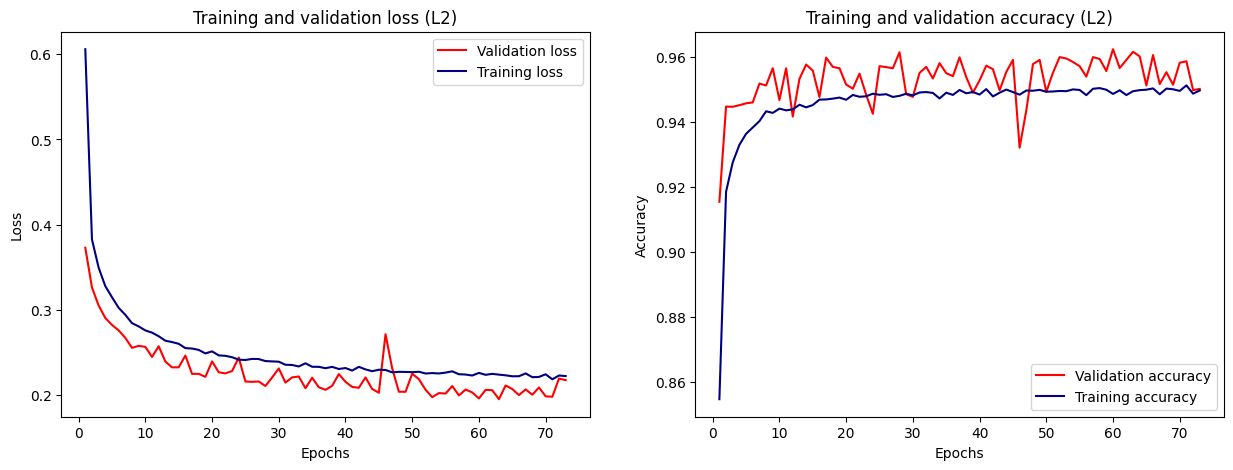

In [26]:
history = model_reg.history.history
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']
training_loss = history['loss']
training_accuracy = history['accuracy']
epochs = range(1, len(val_loss) + 1)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(epochs, val_loss, 'r', label='Validation loss')
ax[0].plot(epochs, training_loss, 'navy', label='Training loss')
ax[0].set_title('Training and validation loss (L2)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax[1].plot(epochs, training_accuracy, 'navy', label='Training accuracy')
ax[1].set_title('Training and validation accuracy (L2)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

The results look promising, the dropping out of neurons and the L2 (Ridge) improved the result because as the graphs show the the validation loss is below and the training loss is only slightly above the validaton loss. They also both plateaued and barely changed overall. This is further proven by the accuracy graph shown where the validation accuracy is overall higher than the training accuracy which means the model generalized better on unseen data. Now let's use this mode for the final evaluation of the test data.

In [30]:
print('Accuracy for training set:', model_reg.evaluate(X_train, y_train)[1])
print('Accuracy for test set:', model_reg.evaluate(X_test, y_test)[1])

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9631 - loss: 0.1854
Accuracy for training set: 0.963871419429779
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9636 - loss: 0.1942
Accuracy for test set: 0.9634000062942505


Looks good! We got an accuracy of about 96% without overfitting on the training data, so this model works much better on classifying the stars.

## t-SNE plot

For the grand finale of this project, I will be making a t-sne plot to visualize the 3 different classes in t-sne plot by reducing the dimensionality so we can see how the algorithim distributes all the points across the 3 classes. Since the features show multicollinearity and the data is non-linear in nature t-sne plots will be a better option than pca analysis.

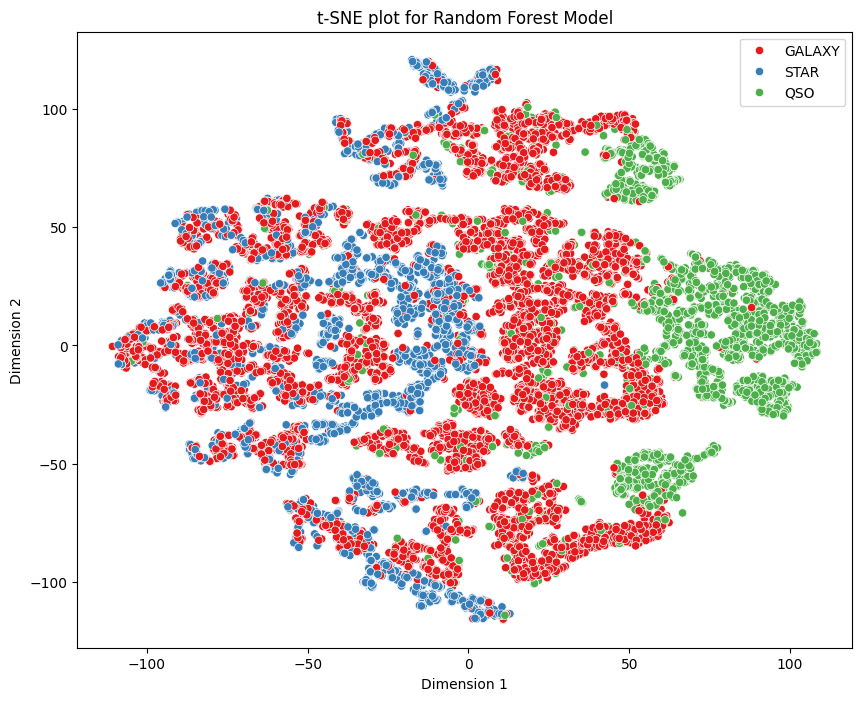

In [28]:
from sklearn.manifold import TSNE
from sklearn.utils import resample

X = stars_new.drop('class', axis=1)
y = stars_new['class']

X_sampled, y_sampled = resample(X, y, n_samples=int(0.2 * len(X)), random_state=42)

#tsne for random forest model
y_pred = rf.predict(X_sampled)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sampled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_pred, palette='Set1')
plt.title('t-SNE plot for Random Forest Model')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Looking at the plot for the random forest model we can interpret the model did a overall good job of separating the classes. We can see that Quasars (QSO) is mostly on the right side of dimesnion 1, above 50. Galaxies seem to span most the of the dimension units from -100 to 50 indicating they have vast spread in the data, and this good because the Galaxies are made of Stars and Quasars. Although their redshifts don't go as high as Quasar redshifts. Finally stars are mostly on the left side relative to dimension 1, not exceeding 0, which means stars have lowest redshift which the model classified correctly.

For the final plot I will make t-sne plot for the regularized neural network model.

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step


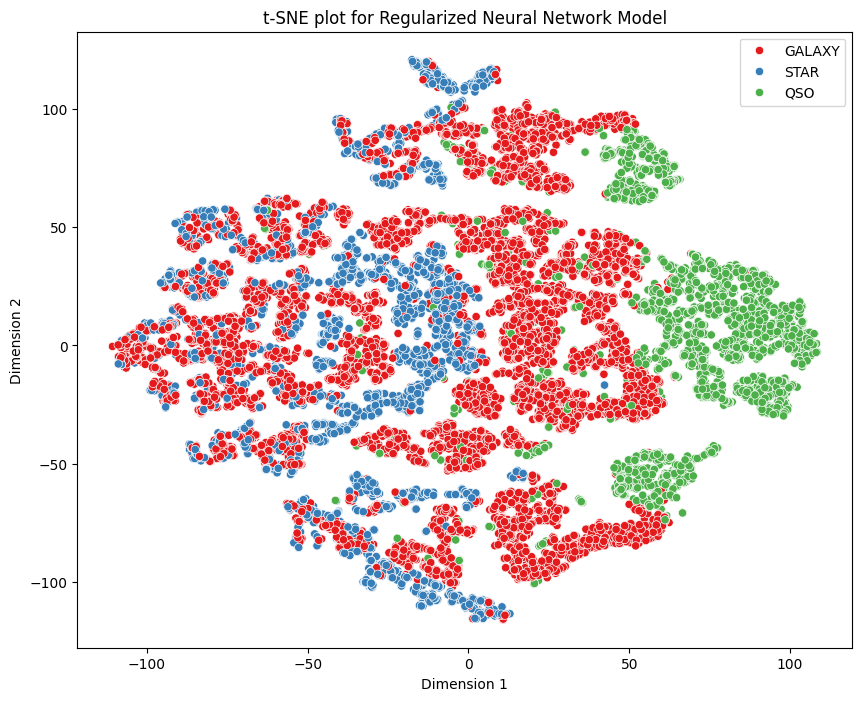

In [29]:
y_pred = model_reg.predict(X_sampled)
y_pred = np.argmax(y_pred, axis=1)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sampled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=label_encoder.inverse_transform(y_pred), palette='Set1')
plt.title('t-SNE plot for Regularized Neural Network Model')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Conclusion

Looking at the t-SNE plots for both random forests and the regularized neural network model it is clear that both models overall performed pretty well. There are clear groups of the 3 classes being shown. The most clear distinction is of the Quasar group while there is some overalapping between Stars and Galaxies. This is expected because Quasar's are extremely high energy objects with more intense redshifts so the model will have easier time recognizing the distinction between Stars/Galaxies and Quasars. Also, because Galaxies are mostly made of Stars with some Galaxies having a higher Star density hense higher redhsifts and some having lower Star density hence lower redshifts. This proven by the vast spread of Galaxy points in the t-SNE plots, which indicates dimension 1 was most likely effected by redhsift. The decision tree and random forest model show that the most used feature was redshift to dicern between what classifies as a Star, Galaxy or Quasar. It achieved a accuracy score 97%! The neural network model while performing good also got accuracy of ~97% needed some L2 regularization to soften the effect of overfitting. After L2 the model perfomed I would say as good as random forest or even better and got accuracy of ~96% with no real indication of overfitting. This is evident by the training/validation loss/accuracy graphs before L2 and after L2, which indicate the model perfomed way better after regularization was added since the validation loss was lower than training loss and validation accuracy was higher or the same as training accuracy. The regularization and random forest was important since the intial data wrangling showed us multicollinearity between the features which was expected because we are analyzing the redhshift/light of interstellar objects in space and filters 'u','g','z' make the redshift/light.

Although the models perfomed extremely well we could explore other models like logistic regression, gradient boosting, or Support Vector Machines and see how well they perform keeping in  mind multicollinearity and overfitting. Better space instrumentation like more powerful and robust telescopes could also give us better data which is more pure. Current telescopes like James Webb are doing exactly that, and data exploration from these telescopes will surely give more insights about our universe and it's composition.